# Digital Musicology (DH-401)
## Assignment 1: Discovering meter
Group 6
- Mickaël Achkar
- Yichen Wang
- Yinghui Jiang

Rough outline
## 0. Data preparation
## 1. From musical score to metrical weights
## 2. From metrical weights to periodicities
## 3. From periodicities to time signature
## 4. Accuracy of classification

#TODO:
- consider grace notes as normal notes (replace 'duration' with 'nominal_duration',
because 'duration' is empty for them) -> check before/after impact to classification
- we also need to sum up durations of tied notes based on piece and staff and voice
- use appropriate method to extract frequencies/periodicities
- use appropriate method to infer time signature
- create simple classification accuracy measure with Ground Truth

In [129]:
import ms3
import pandas as pd
import numpy as np
import math
import fractions
import matplotlib.pyplot as plt
from scipy.fftpack import rfft, rfftfreq
from scipy.signal import find_peaks, get_window
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  
from sklearn import metrics

## 0. Data preparation

In [15]:
# This is the time unit of 'global_onset' used in the dataset
time_unit = 1/4

meter_dataset = pd.read_csv('DM2022 - Assignment 1 [Dataset].csv', index_col = 0, converters = {'global_onset':fractions.Fraction, 'duration': fractions.Fraction})
df = meter_dataset[['piece','timesig','global_onset', 'staff', 'voice', 'duration', 'nominal_duration', 'tied', 'gracenote']]

# Ignore gracenotes for now
df = df[df['gracenote'].isna()]

timesignatures = [fractions.Fraction(timesig) for timesig in df['timesig']]
max_bar_length = max(timesignatures)

In [16]:
%%time

tied_df = df.sort_values(by=['piece','staff','voice','global_onset']).reset_index()

# Aggregating ties (to verify if this is worse or better)
blocks = (tied_df.tied.ne(tied_df.tied.shift()) & tied_df.tied.ne(tied_df.tied.shift() - 2) & tied_df.tied.ne(tied_df.tied.shift() - 1)).cumsum()
tied_df = tied_df.groupby(blocks, as_index=False).agg({'piece':'first','staff':'first', 'voice':'first', 'timesig':'first', 'global_onset':'first', 'tied':'first', 'duration':'sum'})
old_df = df

# not optimized
# tied_df = pd.DataFrame(columns=['piece', 'staff', 'voice', 'global_onset', 'duration', 'tied', 'timesig'])
# for index, row in wdf.iterrows():
#     if pd.isnull(row['tied']):
#         tied_df.loc[index]=row
#     if row['tied'] == 1:
#         tied_df.loc[index]=row
#         subindex = index
#         while wdf.loc[subindex + 1]['tied'].item() == 0:
#             tied_df.loc[index]['duration'] += wdf.loc[subindex + 1]['duration']
#             subindex += 1
#         else:
#             tied_df.loc[index]['duration'] += wdf.loc[subindex + 1]['duration']


CPU times: user 2.31 s, sys: 41 ms, total: 2.35 s
Wall time: 2.36 s


In [279]:
df = tied_df
# df = old_df

## 1. From musical score to metrical weights

Smallest note length in dataset: 1/32


,piece,timesig,global_onset,staff,voice,duration,nominal_duration,tied,gracenote
269850,K309-1,4/4,0,1,1,1/2,1/2,NaN,NaN
269852,K309-1,4/4,2,1,1,1/2,1/2,NaN,NaN
269854,K309-1,4/4,4,1,1,3/8,1/4,NaN,NaN
269856,K309-1,4/4,11/2,1,1,1/16,1/16,NaN,NaN
269858,K309-1,4/4,23/4,1,1,1/16,1/16,NaN,NaN
...,...,...,...,...,...,...,...,...,...
272217,K309-1,4/4,617,1,1,1/4,1/4,NaN,NaN
272218,K309-1,4/4,617,1,1,1/4,1/4,NaN,NaN
272221,K309-1,4/4,618,1,1,1/4,1/4,NaN,NaN
272222,K309-1,4/4,618,1,1,1/4,1/4,NaN,NaN


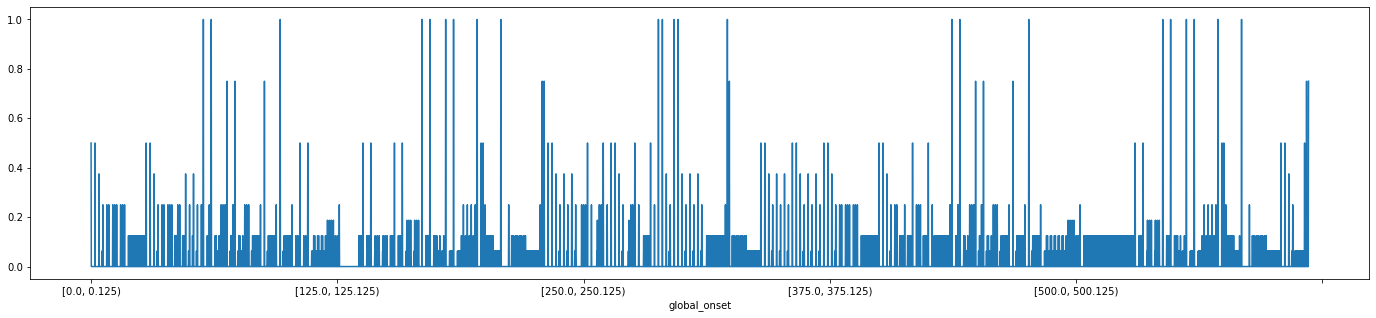

In [17]:
# Select one piece and staff (time signature may change per staff)
one_piece_staff = df[(df['piece'] == 'K309-1') & (df['staff'] == 1)]

# To fine-tune sampling, get minimum note duration among all notes in the piece/staff
min_note = float(one_piece_staff['duration'].min())
print("Smallest note length in dataset:", fractions.Fraction(min_note))

sampling_period = min_note/time_unit
total_piece_duration = one_piece_staff['global_onset'].max()

# Partition the global_onsets in bins
bins = np.arange(0, (total_piece_duration+sampling_period+1e-10), sampling_period)
binned_onsets = pd.cut(one_piece_staff['global_onset'], bins, right = False)

# Compute the sum of durations of all events with onsets in each bin
summed_durations = one_piece_staff.groupby(binned_onsets)['duration'].sum().apply(float)
summed_durations.plot(figsize=(24,5));

one_piece_staff

In [19]:
%%time

# For all pieces and staves (This operation takes around 2-3 minutes on our computer)

# Create dictionaries of total piece durations and smallest notes in each piece/staff
total_piece_durations_df = df.groupby(['piece','staff'])['global_onset'].max().apply(float)
minimum_note_durations_df = df.groupby(['piece','staff'])['duration'].min().apply(float)
total_piece_durations = total_piece_durations_df.to_dict()
minimum_note_durations = minimum_note_durations_df.to_dict()

summed_durations = {}
for key,value in total_piece_durations.items():
    piece_staff = df[(df['piece'] == key[0]) & (df['staff'] == key[1])]

    min_note = minimum_note_durations[key]
    sampling_period = min_note/time_unit

    bins = np.arange(0, (value+sampling_period+1e-10), sampling_period)
    binned_onsets = pd.cut(piece_staff['global_onset'], bins, right = False)
    summed_durations[key] = piece_staff.groupby(binned_onsets)['duration'].sum().apply(float)

CPU times: user 1min 20s, sys: 305 ms, total: 1min 20s
Wall time: 1min 21s


Metrical weights of Piece: n04op18-4_04, Staff: 1, Time Signature: 2/2


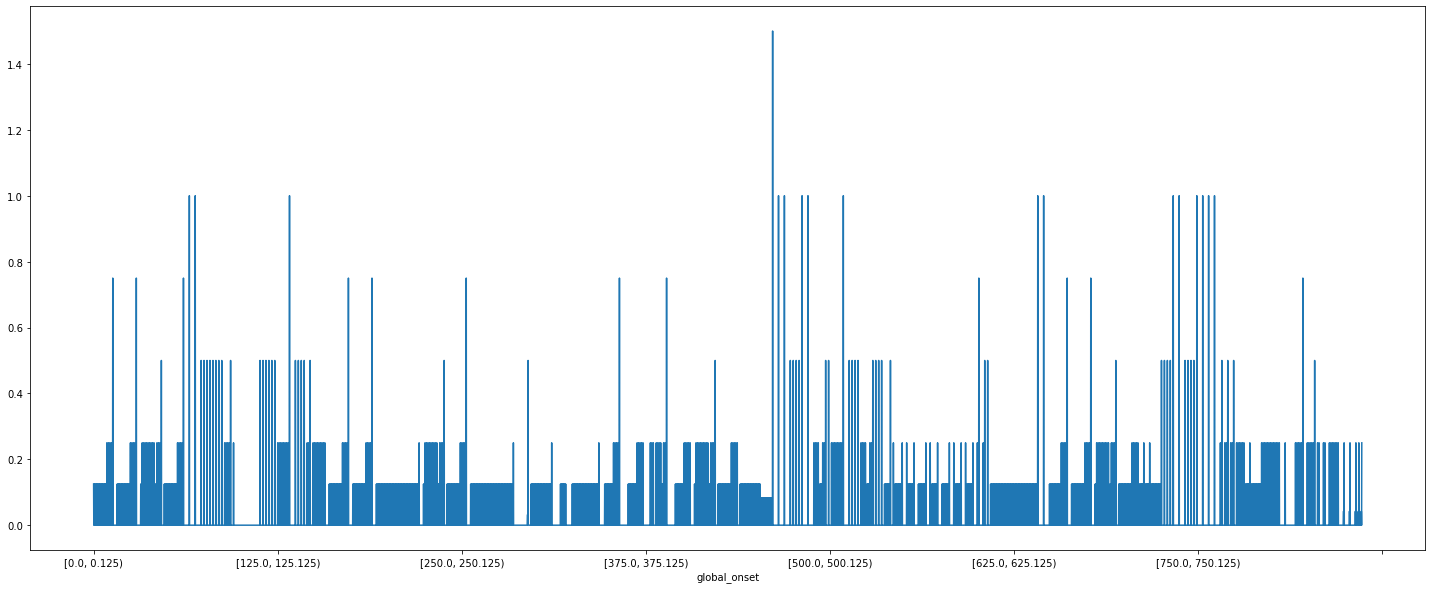

In [20]:
# Now we can plot the metrical weights of a random piece + staff
random_piece_staff = df[['piece', 'staff']].sample(n=1).to_records(index=False)
key = tuple(random_piece_staff[0])

# Get timesignature for reference
timesig = df[(df['piece'] == key[0]) & (df['staff'] == key[1])]['timesig'].sample(n=1).item()

print("Metrical weights of Piece: {piece}, Staff: {staff}, Time Signature: {timesig}".format(piece = key[0], staff = key[1], timesig=timesig))

# Plot metrical weights
summed_durations[key].plot(figsize=(25,10));


## 2. From metrical weights to periodicities

Periodicity analysis of Piece: n04op18-4_04, Staff: 1, Time Signature: 2/2


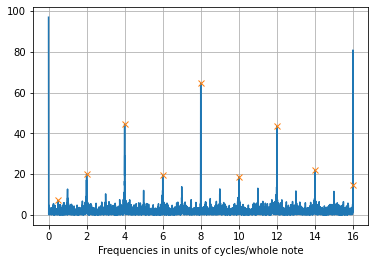

   frequency (cycles/whole note) period (1/f)  amplitude
4                       7.998839          1/8  64.494385
2                       3.999419          1/4  44.372173
6                      11.998258         1/12  43.380902
7                      14.000290         1/14  21.913465
1                       2.002032          1/2  19.968714
3                       6.001452          1/6  19.605459
5                      10.000871         1/10  18.688050
8                      15.993032         1/16  14.452442
0                       0.501669      199/100   7.073261


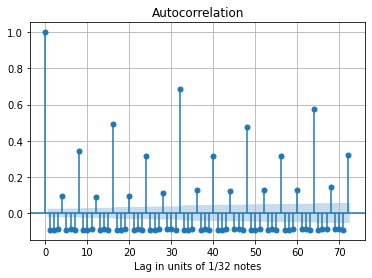

   lag (whole notes)  autocorrelation
32                 1         0.686139
64                 2         0.576213
16               1/2         0.490618
48               3/2         0.477614
8                1/4         0.342337
72               9/4         0.322416
24               3/4         0.317811
40               5/4         0.316390
56               7/4         0.312794
68              17/8         0.142893
60              15/8         0.129412
52              13/8         0.126141
36               9/8         0.124466
44              11/8         0.121874
28               7/8         0.109175
20               5/8         0.095836
4                1/8         0.093841
12               3/8         0.090524


/Users/yichenwang/opt/anaconda3/envs/dm/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [21]:
print("Periodicity analysis of Piece: {piece}, Staff: {staff}, Time Signature: {timesig}".format(piece = key[0], staff = key[1], timesig=timesig))

x = summed_durations[key].index.tolist()
y = summed_durations[key].tolist()

# Number of sample points
N = len(x)
# Sample spacing (in units of time_unit)
T = x[1].left

################################################################
# Window the signal to reduce spectral leakage in the FFT (a good practise)
window = get_window('hann', N)

# Compute Fourier transform of signal
yf = rfft(y * window)
xf = rfftfreq(N, T)
# Convert frequencies to units of cycles/whole note
xf = xf/time_unit
# Convert Fourier output to real-valued amplitudes
amplitudes = np.abs(yf)

# Find significant peaks (using min distance between neighbouring peaks)
peaks, _ = find_peaks(amplitudes, distance=N*.07)

##### Plot Right Fast Fourier Transform #####
plt.plot(xf, amplitudes)
plt.plot(xf[peaks], amplitudes[peaks], "x")
plt.xlabel('Frequencies in units of cycles/whole note')
plt.grid()
plt.show()

##### Get top frequencies (and periods) #####
fourier_peaks = np.array(tuple(zip(xf[peaks], 1/xf[peaks], amplitudes[peaks])))
# Create DataFrame
fourier_df = pd.DataFrame(fourier_peaks, columns = ['frequency (cycles/whole note)', 'period (1/f)', 'amplitude'])
# Convert period (1/f) to Fractions
fourier_df['period (1/f)'] = [fractions.Fraction(period).limit_denominator(100) for period in fourier_df['period (1/f)']]
# Sort in descending order
fourier_df_sorted = fourier_df.sort_values(by='amplitude', ascending=False)
print(fourier_df_sorted)

################################################################
# Create a window with the first few lags
# The window length will correspond to the maximum bar length (time signature) found in the dataset in the units of whole notes
nlags = math.ceil(max_bar_length / (T*time_unit))

##### Plot autocorrelations with respect to first few lags #####
plot_acf(y, lags=nlags)
plt.xlabel('Lag in units of {} notes'.format(fractions.Fraction(T*time_unit).limit_denominator(100)))
plt.grid()
plt.show()

##### Get top autocorrelations #####
autocorr = sm.tsa.acf(y, nlags=nlags)
# Convert lags in units of whole notes
converted_lags = range(len(autocorr)) * (T*time_unit)
# Create DataFrame
autocorr_df = pd.DataFrame(tuple(zip(converted_lags, autocorr)), columns = ['lag (whole notes)','autocorrelation'])
# Convert lags to Fractions
autocorr_df['lag (whole notes)'] = [fractions.Fraction(onset).limit_denominator(100) for onset in autocorr_df['lag (whole notes)']]
# Sort in descending order
autocorr_df_sorted = autocorr_df.sort_values(ascending=False, by='autocorrelation').where(autocorr_df.autocorrelation > 0).dropna().drop(0)
print(autocorr_df_sorted)



## 3. From periodicities to time signature

In [ ]:
rfdf = df.groupby(['piece', 'staff' ,'timesig'], as_index=False).agg(' '.join).iloc[::]
rfdf = rfdf.drop(columns = 'nominal_duration')
periodicities = []
for i in rfdf.itertuples():
    piece = i[1]
    staff = i[2]
    piece_staff = (piece, staff)
    tops = top_periodicities(piece_staff)
    periodicities.append(tops)


In [131]:
def top_periodicities(piece_staff):
    x = summed_durations[piece_staff].index.tolist()
    y = summed_durations[piece_staff].tolist()
    
    # Number of sample points
    N = len(x)
    # Sample spacing (in units of time_unit)
    T = x[1].left
    
    ################################################################
    # Create a window with the first few lags
    # The window length will correspond to the maximum bar length (time signature) found in the dataset in the units of whole notes
    nlags = math.ceil(max_bar_length / (T*time_unit))

    ##### Get top autocorrelations #####
    autocorr = sm.tsa.acf(y, nlags=nlags)
    # Convert lags in units of whole notes
    converted_lags = range(len(autocorr)) * (T*time_unit)
    # Create DataFrame
    autocorr_df = pd.DataFrame(tuple(zip(converted_lags, autocorr)), columns = ['lag (whole notes)','autocorrelation'])
    # Convert lags to Fractions
    autocorr_df['lag (whole notes)'] = [fractions.Fraction(onset).limit_denominator(100) for onset in autocorr_df['lag (whole notes)']]
    # Sort in descending order
    autocorr_df_sorted = autocorr_df.sort_values(ascending=False, by='autocorrelation').where(autocorr_df.autocorrelation > 0).dropna().drop(0)
    #print(autocorr_df_sorted.iloc[:10,0])
    tops = autocorr_df_sorted.iloc[:10,0].to_numpy()
    return tops
    

In [132]:
df_autocorr = pd.DataFrame(periodicities, columns=['p01','p02','p03','p04','p05','p06','p07','p08','p09','p10',])
df_final= pd.concat([rfdf,df_autocorr],axis=1)
df_final

,piece,staff,timesig,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10
0,K279-1,1,4/4,1,2,1/4,1/2,3/2,3/4,9/4,5/4,7/4,5/8
1,K279-1,2,4/4,2,1/4,1/2,7/4,9/4,1,3/2,1/8,3/4,5/4
2,K279-2,1,3/4,3/4,1/4,1/2,3/2,9/4,5/4,1,7/4,2,3/32
3,K279-2,2,3/4,1/4,3/4,1/2,3/2,1,5/4,2,218/97,173/99,233/100
4,K279-3,1,2/4,1/2,1,2,3/2,1/8,1/4,17/8,9/8,3/8,5/8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,n16op135_04,2,4/4,2,1/2,3/2,1,1/4,3/4,7/4,9/4,5/4,None
470,n16op135_04,3,3/2,1,2,1/2,3/2,9/4,7/4,5/4,3/4,1/4,None
471,n16op135_04,3,4/4,1,2,1/2,3/2,9/4,7/4,5/4,3/4,1/4,None
472,n16op135_04,4,3/2,1,2,3/2,1/2,5/4,1/4,9/4,3/4,7/4,None


In [133]:
X= df_final.iloc[:,3:6].values
y= df_final.iloc[:,2].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [134]:
model = RandomForestClassifier(n_estimators=100,bootstrap = True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4789915966386555


In [127]:
y_test

array(['6/8', '3/4', '3/4', '3/4', '4/4', '2/2', '6/8', '4/4', '4/4',
       '4/4', '2/4', '6/8', '9/4', '3/4', '3/4', '3/4', '3/4', '3/4',
       '4/4', '6/8', '3/4', '4/4', '6/4', '3/4', '2/4', '4/4', '4/4',
       '3/8', '6/8', '3/4', '2/4', '4/4', '3/4', '6/8', '4/4', '2/2',
       '3/8', '3/4', '2/2', '6/8', '4/4', '4/4', '2/2', '3/4', '2/4',
       '2/4', '2/4', '9/4', '6/8', '2/2', '2/2', '2/4', '3/4', '3/4',
       '6/8', '3/4', '3/4', '2/4', '2/4', '4/4', '6/8', '3/4', '2/2',
       '2/4', '2/4', '6/8', '2/2', '3/8', '4/4', '2/4', '2/2', '2/4',
       '2/4', '2/4', '2/2', '3/4', '3/4', '3/4', '2/4', '3/4', '3/8',
       '4/4', '3/4', '3/4', '3/4', '2/4', '3/4', '3/8', '3/4', '4/4',
       '2/2', '4/4', '2/4', '3/4', '3/4', '3/4', '3/4', '6/8', '4/4',
       '9/8', '6/8', '6/8', '3/8', '2/2', '4/4', '3/2', '2/2', '6/8',
       '3/8', '2/2', '6/8', '2/4', '3/4', '2/4', '3/4', '2/4', '6/8',
       '4/4', '4/4'], dtype=object)

In [128]:
y_pred

array(['3/4', '3/4', '2/2', '3/4', '2/4', '2/2', '3/4', '2/2', '2/2',
       '3/4', '4/4', '3/4', '2/4', '3/4', '3/4', '4/4', '3/4', '3/4',
       '2/2', '2/2', '3/4', '2/4', '2/2', '3/4', '3/4', '2/2', '4/4',
       '6/8', '6/8', '3/4', '3/4', '3/4', '3/4', '3/8', '2/2', '2/2',
       '3/8', '3/4', '3/4', '2/2', '2/4', '4/4', '2/2', '3/4', '2/4',
       '2/4', '3/4', '3/4', '3/4', '4/4', '2/2', '2/4', '3/4', '3/4',
       '3/4', '3/4', '2/2', '2/4', '2/4', '4/4', '2/4', '4/4', '2/2',
       '3/4', '2/4', '3/8', '3/4', '3/8', '2/4', '4/4', '3/4', '2/4',
       '2/4', '2/4', '3/4', '3/4', '2/2', '3/4', '3/4', '3/4', '2/4',
       '2/4', '3/4', '2/4', '3/4', '4/4', '3/4', '3/8', '3/4', '4/4',
       '2/2', '2/2', '3/8', '3/4', '4/4', '3/4', '3/4', '3/8', '2/2',
       '2/4', '3/4', '3/8', '3/8', '2/4', '4/4', '2/2', '2/2', '3/4',
       '3/8', '3/4', '3/4', '2/4', '3/4', '2/4', '3/4', '2/4', '3/8',
       '4/4', '2/2'], dtype=object)